In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("a2015003713/militaryaircraftdetectiondataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/militaryaircraftdetectiondataset


In [2]:
from datasets import load_dataset

dataset = load_dataset("imagefolder", data_dir="/kaggle/input/militaryaircraftdetectiondataset/crop")

Resolving data files:   0%|          | 0/32277 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [3]:
dataset = dataset.rename_column("label", "labels")


In [4]:
dataset['train'][0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1768x706>,
 'labels': 0}

In [5]:
shuffled_dataset = dataset['train'].shuffle(seed=42)

In [6]:
shuffled_dataset

Dataset({
    features: ['image', 'labels'],
    num_rows: 32277
})

In [7]:
from transformers import ViTImageProcessor

model_name_or_path = 'google/vit-base-patch16-224-in21k'
processor = ViTImageProcessor.from_pretrained(model_name_or_path)

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

In [8]:
processor

ViTImageProcessor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

In [9]:
input_dataset = shuffled_dataset.train_test_split(test_size=0.2)

In [10]:
input_dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'labels'],
        num_rows: 25821
    })
    test: Dataset({
        features: ['image', 'labels'],
        num_rows: 6456
    })
})

In [11]:
def process_example(example):
    inputs = processor(example['image'], return_tensors = 'pt')
    inputs['labels'] = example['labels']
    return inputs

In [12]:
process_example(input_dataset['train'][0])

{'pixel_values': tensor([[[[0.5451, 0.5451, 0.5451,  ..., 0.4745, 0.5216, 0.4667],
          [0.5451, 0.5451, 0.5451,  ..., 0.4745, 0.5216, 0.4745],
          [0.5451, 0.5451, 0.5451,  ..., 0.4824, 0.5137, 0.4824],
          ...,
          [0.5529, 0.5529, 0.5529,  ..., 0.7020, 0.7020, 0.7020],
          [0.5608, 0.5608, 0.5608,  ..., 0.7020, 0.7020, 0.7020],
          [0.5608, 0.5608, 0.5608,  ..., 0.7020, 0.7020, 0.7020]],

         [[0.4745, 0.4745, 0.4745,  ..., 0.4431, 0.4824, 0.4275],
          [0.4745, 0.4745, 0.4745,  ..., 0.4431, 0.4824, 0.4353],
          [0.4745, 0.4745, 0.4745,  ..., 0.4431, 0.4745, 0.4431],
          ...,
          [0.4667, 0.4667, 0.4667,  ..., 0.6157, 0.6157, 0.6157],
          [0.4745, 0.4745, 0.4745,  ..., 0.6157, 0.6157, 0.6157],
          [0.4745, 0.4745, 0.4745,  ..., 0.6157, 0.6157, 0.6157]],

         [[0.7020, 0.7020, 0.7020,  ..., 0.6235, 0.6627, 0.6078],
          [0.7020, 0.7020, 0.7020,  ..., 0.6235, 0.6627, 0.6157],
          [0.7020, 0.7020

In [13]:
def transform(batch):
    inputs = processor([x for x in batch['image']], return_tensors = 'pt')
    inputs['labels'] = batch['labels']
    return inputs

In [14]:
prepared_ds = input_dataset.with_transform(transform)

In [15]:
prepared_ds['train'][0:2]

{'pixel_values': tensor([[[[ 0.5451,  0.5451,  0.5451,  ...,  0.4745,  0.5216,  0.4667],
          [ 0.5451,  0.5451,  0.5451,  ...,  0.4745,  0.5216,  0.4745],
          [ 0.5451,  0.5451,  0.5451,  ...,  0.4824,  0.5137,  0.4824],
          ...,
          [ 0.5529,  0.5529,  0.5529,  ...,  0.7020,  0.7020,  0.7020],
          [ 0.5608,  0.5608,  0.5608,  ...,  0.7020,  0.7020,  0.7020],
          [ 0.5608,  0.5608,  0.5608,  ...,  0.7020,  0.7020,  0.7020]],

         [[ 0.4745,  0.4745,  0.4745,  ...,  0.4431,  0.4824,  0.4275],
          [ 0.4745,  0.4745,  0.4745,  ...,  0.4431,  0.4824,  0.4353],
          [ 0.4745,  0.4745,  0.4745,  ...,  0.4431,  0.4745,  0.4431],
          ...,
          [ 0.4667,  0.4667,  0.4667,  ...,  0.6157,  0.6157,  0.6157],
          [ 0.4745,  0.4745,  0.4745,  ...,  0.6157,  0.6157,  0.6157],
          [ 0.4745,  0.4745,  0.4745,  ...,  0.6157,  0.6157,  0.6157]],

         [[ 0.7020,  0.7020,  0.7020,  ...,  0.6235,  0.6627,  0.6078],
          [ 0

In [16]:
def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["labels"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

In [17]:
import torch
from torch.utils.data import DataLoader
train_dataloader = DataLoader(prepared_ds["train"], collate_fn=collate_fn, batch_size=4)
batch = next(iter(train_dataloader))
for k,v in batch.items():
  if isinstance(v, torch.Tensor):
    print(k, v.shape)

pixel_values torch.Size([4, 3, 224, 224])
labels torch.Size([4])


In [18]:
from sklearn.metrics import accuracy_score
import numpy as np

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return dict(accuracy=accuracy_score(predictions, labels))

In [19]:
from transformers import ViTForImageClassification
labels = input_dataset['train'].features['labels'].names
model = ViTForImageClassification.from_pretrained(
    model_name_or_path,
    num_labels = len(labels),
    label2id = {c:i for i,c in enumerate(labels)},
    id2label = {i:c for i,c in enumerate(labels)}
)

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [24]:
from transformers import TrainingArguments

training_args = TrainingArguments(
  output_dir="./vit-base-beans",
  per_device_train_batch_size=16,
  evaluation_strategy="steps",
  num_train_epochs=2,
  fp16=True,
  save_steps=100,
  eval_steps=100,
  logging_steps=10,
  learning_rate=2e-4,
  save_total_limit=2,
  remove_unused_columns=False,
  push_to_hub=False,
  report_to='tensorboard',
  load_best_model_at_end=True,
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [25]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=prepared_ds["train"],
    eval_dataset=prepared_ds["test"],
    tokenizer=processor,
)

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


In [26]:
prepared_ds["train"]

Dataset({
    features: ['image', 'labels'],
    num_rows: 25821
})

In [27]:
train_results = trainer.train()

Step,Training Loss,Validation Loss,Accuracy
100,3.592400,3.567479,0.192689
200,3.018900,3.031259,0.304678
300,2.554100,2.557483,0.395601
400,2.114000,2.233164,0.457094
500,1.962400,1.945490,0.559634
600,1.674900,1.736968,0.578686
700,1.585200,1.494718,0.643897
800,1.187500,1.415139,0.646840
900,1.511400,1.270911,0.682001
1000,1.312200,1.194018,0.693928


In [28]:
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

***** train metrics *****
  epoch                    =          2.0
  total_flos               = 3729410254GF
  train_loss               =       0.9726
  train_runtime            =   1:25:45.55
  train_samples_per_second =       10.036
  train_steps_per_second   =        0.627


In [29]:
metrics = trainer.evaluate(prepared_ds['test'])
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

***** eval metrics *****
  epoch                   =        2.0
  eval_accuracy           =     0.9027
  eval_loss               =     0.3643
  eval_runtime            = 0:01:47.33
  eval_samples_per_second =      60.15
  eval_steps_per_second   =      7.519


In [30]:
outputs = trainer.predict(prepared_ds['test'])
print(outputs.metrics)

{'test_loss': 0.36434125900268555, 'test_accuracy': 0.90272614622057, 'test_runtime': 107.5304, 'test_samples_per_second': 60.039, 'test_steps_per_second': 7.505}


In [32]:
from sklearn.metrics import recall_score

# Calculate the recall scores
# 'None' calculates recall for each class separately
recall = recall_score(y_true, y_pred, average=None)

# Print the recall for each class
for label, score in zip(labels, recall):
    print(f'Recall for {label}: {score:.2f}')

Recall for A10: 0.94
Recall for A400M: 0.90
Recall for AG600: 0.89
Recall for AH64: 0.86
Recall for AV8B: 0.91
Recall for An124: 0.78
Recall for An22: 0.80
Recall for An225: 0.55
Recall for An72: 0.90
Recall for B1: 0.95
Recall for B2: 0.97
Recall for B21: 0.00
Recall for B52: 0.90
Recall for Be200: 0.90
Recall for C130: 0.96
Recall for C17: 0.84
Recall for C2: 0.93
Recall for C390: 0.65
Recall for C5: 0.86
Recall for CH47: 0.98
Recall for CL415: 0.97
Recall for E2: 0.92
Recall for E7: 0.97
Recall for EF2000: 0.94
Recall for F117: 0.97
Recall for F14: 0.78
Recall for F15: 0.93
Recall for F16: 0.87
Recall for F18: 0.93
Recall for F22: 0.90
Recall for F35: 0.93
Recall for F4: 0.95
Recall for H6: 0.96
Recall for J10: 0.91
Recall for J20: 0.92
Recall for JAS39: 0.88
Recall for JF17: 0.67
Recall for JH7: 0.86
Recall for KC135: 0.94
Recall for KF21: 0.83
Recall for KJ600: 0.20
Recall for Ka27: 0.74
Recall for Ka52: 0.90
Recall for MQ9: 0.94
Recall for Mi24: 0.93
Recall for Mi26: 0.80
Recall 

In [43]:
trainer.push_to_hub("SouthMemphis/ViT_military_aircraft")

model.safetensors:   0%|          | 0.00/343M [00:00<?, ?B/s]

Upload 5 LFS files:   0%|          | 0/5 [00:00<?, ?it/s]

training_args.bin:   0%|          | 0.00/5.18k [00:00<?, ?B/s]

events.out.tfevents.1735228040.35b123c34d0e.40.1:   0%|          | 0.00/85.9k [00:00<?, ?B/s]

events.out.tfevents.1735228020.35b123c34d0e.40.0:   0%|          | 0.00/7.50k [00:00<?, ?B/s]

events.out.tfevents.1735233522.35b123c34d0e.40.2:   0%|          | 0.00/411 [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/SouthMemphis/vit-base-beans/commit/0da872bd5a92e43f7e690543c30ce2236e0f3b8d', commit_message='SouthMemphis/ViT_military_aircraft', commit_description='', oid='0da872bd5a92e43f7e690543c30ce2236e0f3b8d', pr_url=None, pr_revision=None, pr_num=None)

Resolving data files:   0%|          | 0/32277 [00:00<?, ?it/s]

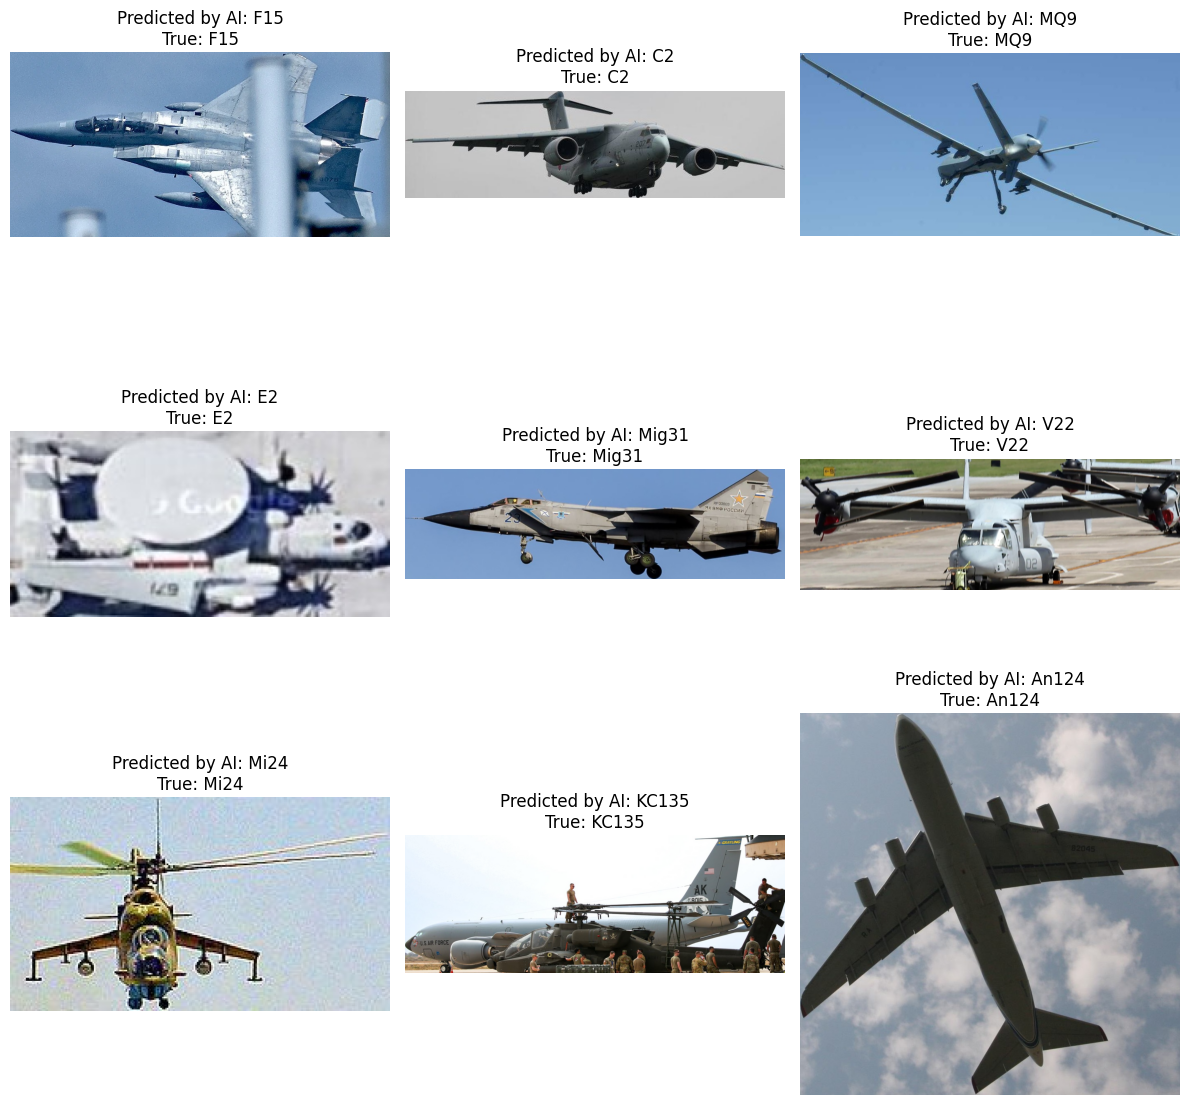

In [64]:
import random
import matplotlib.pyplot as plt
from transformers import AutoImageProcessor, AutoModelForImageClassification
from datasets import load_dataset
import torch
from PIL import Image

model_name = "SouthMemphis/vit-military-aircraft"
processor = AutoImageProcessor.from_pretrained(model_name)
model = AutoModelForImageClassification.from_pretrained(model_name)
dataset = load_dataset("imagefolder", data_dir="/kaggle/input/militaryaircraftdetectiondataset/crop", split='train')
dataset = dataset.rename_column("label", "labels")
random_indices = random.sample(range(len(dataset)), 9)
id2label = model.config.id2label
fig, axes = plt.subplots(3, 3, figsize=(12, 12))


for i, idx in enumerate(random_indices):
    
    image_path = dataset[idx]['image']
    label = dataset[idx]['labels'] 

    inputs = processor(images=image_path, return_tensors="pt")


    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    predicted_class_idx = logits.argmax(-1).item()

    
    predicted_label = model.config.id2label[predicted_class_idx]  
    true_label_idx = dataset[idx]['labels']  
    true_label_name = id2label[true_label_idx]
    ax = axes[i // 3, i % 3]
    ax.imshow(image_path)
    ax.set_title(f"Predicted by AI: {predicted_label}\nTrue: {true_label_name}")
    ax.axis('off')


plt.tight_layout()
plt.show()